In [423]:
import numpy as np
import os
import pandas as pd
import matplotlib as mpl
from pathlib import Path
from PIL import Image as im
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.transforms as mtransforms
from scipy import ndimage as ndi
from matplotlib.patches import Rectangle

%matplotlib inline
%pprint

Pretty printing has been turned OFF


In [424]:
'''
FUNCTIONS FOR READING-IN DATA
'''

def file_list(directory, ftype):
    allflist = sorted(os.listdir(directory))
    flistlen = len(allflist)
    flist = []
    for x in range(flistlen):
        if allflist[x].endswith(str(ftype)):
            flist.append(allflist[x])
    return flist

def txt_to_list(file):
    rows = []
    processedrows = []

    with open(file, 'r') as f:
        listofrows = f.read().split('\n')
        f.close()

    for i in range(len(listofrows)):
        rowcrawler = []
        rawrow = listofrows[i].split('\t')
        rowlength = len(rawrow)
        for j in range(rowlength):
            if rawrow[j] != '':
                rowcrawler.append(int(rawrow[j]))
        rows.append(rowcrawler)

    #rows is a list of lists, where each entry (i.e. rows[0] is a list reading pixels horizontally across camera
    #rows[5] is a list of each value of every pixel in the 6th row of the image
    #rows[x] has ditched the empty value at the end of each list. But there are 257 rows, not 256. So I need to check that
    #the last row is a real value and not junk

    for j in range(len(rows)):
        if bool(rows[j]):
            processedrows.append(rows[j])
        
    # For example, consider:
    #     1 2 3
    #     4 5 6
    #     7 8 9
    # as a 3x3 pixel camera image. processedrows[0] = [1, 2, 3], and processedrows[2] = [7, 8, 9]
    # processed processedrows[hz index][vt index] accesses that pixel, so processedrows[1][2] = 6
    
    return processedrows


In [425]:
class xcam_image:
    
    '''
    ATTRIBUTES AND INITIALIZING
    '''

    def __init__(self, angle, listoflists):
        #Instantiation variables and fundamentals
        self.angle = angle
        self.image_list = listoflists
        self.image_size = None
        self.rotation = 270
        
        #Original and rotated array, read from the list-of-lists
        self.base_image_array = np.array(self.image_list, dtype=np.uint8)
        self.proc_image_array = np.rot90(self.base_image_array, int(self.rotation / 90))
        
        #Ranges for center of mass
        self.xlim_roi = (0, 255)
        self.ylim_roi = (0, 255)       
        
    '''
    SETTER METHODS
    '''
    
    def set_xlim_roi(self, tup): self.xlim_roi = tup
    def set_ylim_roi(self, tup): self.ylim_roi = tup    
    
    def set_image_size(self, scalar): self.image_size = scalar
    def set_rotation(self, n90): 
        if (n90 in [0,90,180,270]): self.rotation = n90 
        else: return print('Error: Rotate must be set to 0, 90, 180, or 270 degrees')    
    
    '''
    GETTER METHODS
    '''
    
    #Instantiation basics
    def get_name(self): return str(self.get_angle()) + ' Degrees'
    def get_angle(self): return self.angle
    def get_image_list(self): return self.image_list
    def get_image_size(self): return self.image_size

    #ROIs for center of mass
    def get_xlim_roi(self): return self.xlim_roi
    def get_ylim_roi(self): return self.ylim_roi    

    #Image display and np arrays
    def get_base_image_array(self): return self.base_image_array
    def get_proc_image_array(self): return self.proc_image_array

    '''
    INTERNAL METHODS
    '''
    
    #Calculate the center of mass within the region of interest
    def _gen_com_array(self):
        xroi, yroi = self.get_xlim_roi(), self.get_ylim_roi()
        proc_array = self.get_proc_image_array() 
        com_list = []
        for x in range(xroi[0], xroi[1]):
            row = []
            for y in range(yroi[0], yroi[1]):
                row.append(proc_array[y][x])
            com_list.append(row)
        com_array = np.rot90(np.array(com_list), -1)
        return com_array
    
    '''
    CALCULATIONS
    '''
    
    def calc_com(self):
        roi = self._gen_com_array()
        com = ndi.center_of_mass(roi)
        com = (com[1] + self.get_xlim_roi()[0], com[0] + self.get_ylim_roi()[0])
        return com

    '''
    DISPLAY METHODS
    '''
    
    #Show x-ray image with white box indicating ROI
    def show_image(self): 
        size = self.get_image_size()
        xroi, yroi = self.get_xlim_roi(), self.get_ylim_roi()
        img = self.get_proc_image_array() 
        if type(size) == int: fig, ax = plt.subplots(figsize = (size, size))
        else: fig, ax = plt.subplots()
        ax.add_patch(Rectangle((xroi[0], yroi[0]), (xroi[1] - xroi[0]), (yroi[1] - yroi[0]), 
                       edgecolor = 'white', fill=False, lw=2))
        plt.imshow(img, cmap = 'nipy_spectral', origin = 'lower')
        plt.colorbar()
        plt.title(self.get_name())
        plt.show()
        return fig, ax
    
    #Plot the ROI. Same array gets fed to calculate COM. Sanity check
    def show_roi(self):
        fig, ax = plt.subplots()
        img = self._gen_com_array()
        plt.imshow(img, cmap = 'nipy_spectral', origin = 'lower')
        plt.colorbar()
        plt.show()
        return fig, ax
    
    #not working how i want :( 
    def show_com(self):
        plot = self.show_image()
        com = self.calc_com()
        xroi, yroi = self.get_xlim_roi(), self.get_ylim_roi()
        plt.scatter(com[0], com[1], marker = 'x', color = 'white', z = 200)
        return 
        

In [427]:
d = '/Users/anthonygironda/Desktop/Rowland_Tracking/'
t = '.txt'
flist = file_list(d, t)
count = len(flist)
print(str(count) + ' files in directory')
print('\n')
print(flist)

37 files in directory


['35_deg.txt', '36_deg.txt', '37_deg.txt', '38_deg.txt', '39_deg.txt', '40_deg.txt', '41_deg.txt', '42_deg.txt', '43_deg.txt', '44_deg.txt', '45_deg.txt', '46_deg.txt', '47_deg.txt', '48_deg.txt', '49_deg.txt', '50_deg.txt', '52_deg.txt', '55_deg.txt', '58_deg.txt', '60_deg.txt', '62_deg.txt', '65_deg.txt', '68_deg.txt', '70_deg.txt', '71_deg.txt', '72_deg.txt', '73_deg.txt', '74_deg.txt', '75_deg.txt', '76_deg.txt', '77_deg.txt', '78_deg.txt', '79_deg.txt', '80_deg.txt', '81_deg.txt', '82_deg.txt', '83_deg.txt']


In [418]:
x_roi_list = [(160, 190), #i = 0
              (160, 190),
              (160, 190),
              (161, 191),
              (161, 191), 
              
              (161, 192), #i = 5
              (161, 192),
              (161, 192),
              (161, 192),
              (161, 193),
              
              (161, 193), #i = 10
              (161, 193),
              (161, 193),
              (161, 193),
              (161, 193),
              
              (162, 192), #i = 15
              (162, 192),
              (162, 192),
              (162, 192),
              (162, 192),
              
              (162, 192), #i = 20
              (162, 192),
              (162, 193),
              (162, 193),
              (162, 193),
              
              (162, 194), #i = 25
              (163, 194),
              (164, 194),
              (164, 194),
              (164, 194),
              
              (164, 194), #i = 30
              (164, 196),
              (164, 196),
              (164, 196),
              (164, 196),
              
              (164, 196), #i = 35
              (164, 196)]

In [419]:
y_roi_list = [(2, 253), #i = 0
              (2, 253),
              (2, 253),
              (2, 253),
              (2, 253),
              
              (2, 253), #i = 5
              (2, 253),
              (2, 253),
              (2, 253),
              (2, 253),
              
              (2, 253), #i = 10
              (2, 253),
              (2, 253),
              (2, 253),
              (2, 253),
              
              (2, 253), #i = 15
              (2, 253),
              (2, 253),
              (2, 253),
              (2, 253),
              
              (2, 253), #i = 20
              (4, 253),
              (8, 253),
              (20, 253),
              (50, 253),
              
              (70, 253), #i = 25
              (80, 253),
              (80, 253),
              (80, 253),
              (64, 253),
              
              (70, 253), #i = 30
              (82, 245), 
              (100, 230), 
              (110, 225), 
              (118, 215), 
              
              (128, 206), #i = 35
              (138, 202)]

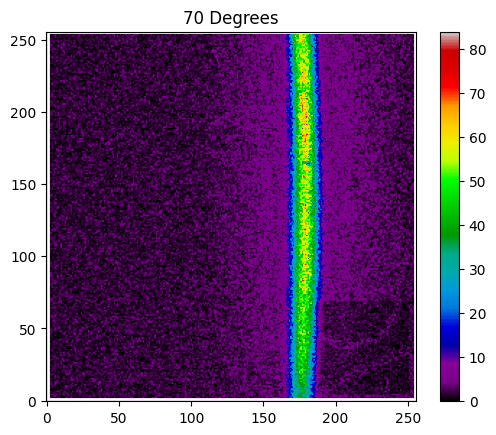

(<Figure size 640x480 with 2 Axes>, <AxesSubplot: title={'center': '70 Degrees'}>)

In [445]:
angle = 70
picture = xcam_image(angle, txt_to_list(d + str(angle) + '_deg' + t))
picture.set_xlim_roi((1, 255))
picture.set_ylim_roi((1, 255))
picture.show_image()


In [436]:
album = []
com_angles = []
com_list = []
for k in range(count):
    angle = int(flist[k][0] + flist[k][1])
    picture = xcam_image(angle, txt_to_list(d + str(angle) + '_deg' + t))
    picture.set_xlim_roi(x_roi_list[k])
    picture.set_ylim_roi(y_roi_list[k])
    album.append(picture)
    com_angles.append(angle)
    com_list.append(picture.calc_com())

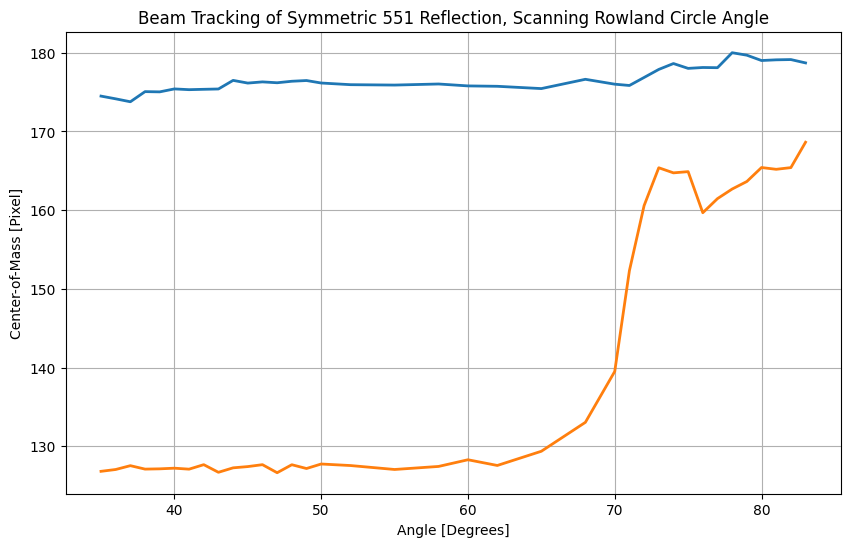

In [441]:
fig, ax = plt.subplots(figsize = (10,6))
ax.plot(com_angles, com_list, linewidth=2.0)
ax.set_xlabel('Angle [Degrees]')
ax.set_ylabel('Center-of-Mass [Pixel]')
ax.set_title('Beam Tracking of Symmetric 551 Reflection, Scanning Rowland Circle Angle') 
ax.grid(True)

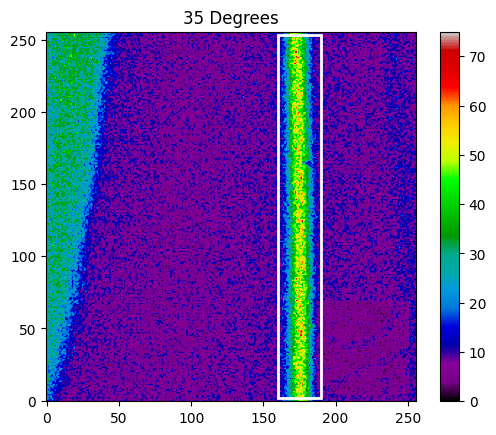

(<Figure size 640x480 with 2 Axes>,
 <AxesSubplot: title={'center': '35 Degrees'}>)

In [371]:
index = 0

# x1 = 163
# x2 = 198
# y1 = 137
# y2 = 203

# album[index].set_xlim_roi((x1, x2))
# album[index].set_ylim_roi((y1, y2))
album[index].show_image()

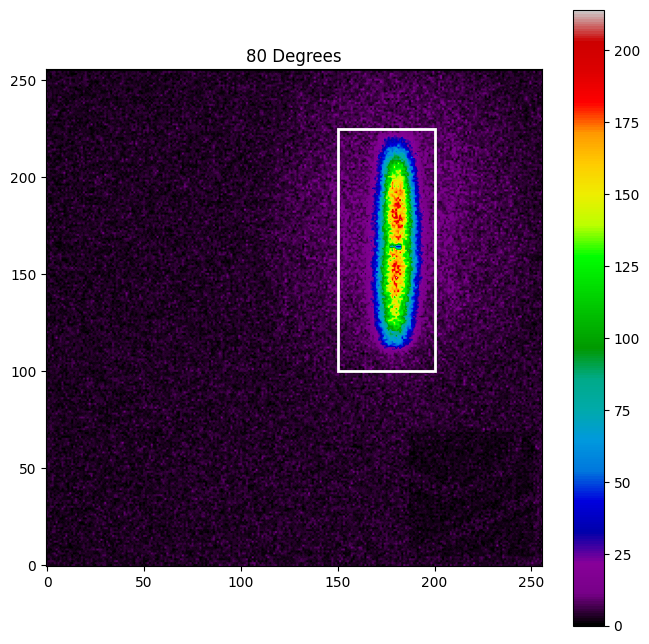

(169.98443680036857, 164.91823268271924)

In [185]:
d = '/Users/anthonygironda/Desktop/Rowland_Tracking/'
typ = '_deg.txt'
angle = 80

l = txt_to_list(d + str(angle) + typ)

x_range = (150, 200)
y_range = (100, 225)
size = None
size = 8

q1 = xcam_image(angle, l)

q1.set_xlim_roi(x_range)
q1.set_ylim_roi(y_range)
q1.set_image_size(size)

q1.show_image()
q1.calc_com()


In [130]:
display(x[156])

IndexError: tuple index out of range

In [53]:
def xcam_helper(angle):
    d = '/Users/anthonygironda/Desktop/Rowland_Tracking/'
    typ = '.txt'
    flist = file_list(directory, ftype)
    l = txt_to_list('/Users/anthonygironda/Desktop/Rowland_Tracking/40_deg.txt')

                  #tiff file(?)
def gen_xcam_set(directory, ftype):
    flist = file_list(directory, ftype)
    #some hardcoded jank right here but it works:
    angles = []
    for q in range(len(flist)):
        angles.append(int((flist[q])[0] + (flist[q])[1]))
    xcam_list = []
    for q in range(len(flist)):
        xcam_list.append(xcam_image(angles[q], txt_to_list(directory + flist[q])))
    setcam = xcam_set(xcam_list)
    return setcam

In [53]:
def xcam_helper(angle):
    d = '/Users/anthonygironda/Desktop/Rowland_Tracking/'
    typ = '.txt'
    flist = file_list(directory, ftype)
    l = txt_to_list('/Users/anthonygironda/Desktop/Rowland_Tracking/40_deg.txt')

                  #tiff file(?)
def gen_xcam_set(directory, ftype):
    flist = file_list(directory, ftype)
    #some hardcoded jank right here but it works:
    angles = []
    for q in range(len(flist)):
        angles.append(int((flist[q])[0] + (flist[q])[1]))
    xcam_list = []
    for q in range(len(flist)):
        xcam_list.append(xcam_image(angles[q], txt_to_list(directory + flist[q])))
    setcam = xcam_set(xcam_list)
    return setcam

In [54]:
class xcam_set:
    
    globe_rotation = None
    globe_normalization = None

    def __init__(self, listofcamobj):
        self.piclist = listofcamobj
    
    def get_len(self): return len(self.piclist)
    def get_angles(self):
        ang = []
        for t in range(self.get_len()):
            ang.append((self.piclist[t]).angle)
        return ang
    def get_com(self): return
    
    def norm(self):
        for t in range(self.get_len()):
            self.piclist[t].set_norm_to_max()
            
    def set_rot(self, n90):
        if (n90 == 0 or n90 == 90 or n90 == 180 or n90 == 270): 
            self.globe_normalization = n90 
            for t in range(self.get_len()):
                self.piclist[t].set_rot(n90)
        else: return print('Error: Rotate must be set to 0, 90, 180, or 270 degrees')

    def set_norm_to_global_max(self):
        gmax = 0
        for t in range(self.get_len()):
            imax = (self.piclist[t]).get_maxcounts()
            if imax > gmax: gmax = imax
        self.globe_normalization = gmax
        for t in range(self.get_len()):
            self.piclist[t].set_norm(gmax)
        
    def show_set(self):
        for t in range(self.get_len()): self.piclist[t].show_pic()

In [55]:
def gen_xcam_set(directory, ftype):
    flist = file_list(directory, ftype)
    #some hardcoded jank right here but it works:
    angles = []
    for q in range(len(flist)):
        angles.append(int((flist[q])[0] + (flist[q])[1]))
    xcam_list = []
    for q in range(len(flist)):
        xcam_list.append(xcam_image(angles[q], txt_to_list(directory + flist[q])))
    setcam = xcam_set(xcam_list)
    return setcam

In [56]:
d = '/Users/anthonygironda/Desktop/Rowland_Tracking/'
typ = '.txt'
l = txt_to_list('/Users/anthonygironda/Desktop/Rowland_Tracking/40_deg.txt')

# p1 = xcam_image(70, l)
# p1.get_base_nparray()
# p1.set_norm(255)
# p1.set_norm_to_max()
# p1.show_pic()
# deg80 = txt_to_list('/Users/anthonygironda/Desktop/Rowland_Tracking/80_deg.txt')
# p2 = xcamimage(80, deg80)

# p1.set_norm_to_max()
# p1.set_rot(90)
# p1.gen_pic()
# # p2.gen_pic()



In [57]:
d = '/Users/anthonygironda/Desktop/Rowland_Tracking/'
typ = '.txt'
r_tracking = gen_xcam_set(d, typ)
r_tracking.set_rot(270)
# r_tracking.show_set()

l = txt_to_list('/Users/anthonygironda/Desktop/Rowland_Tracking/81_deg.txt')
p1 = xcam_image(40, l)
p1.get_maxcounts()
p1.set_norm(80)
# p1.set_norm_to_max()
p1.show_pic()
# deg80 = txt_to_list('/Users/anthonygironda/Desktop/Rowland_Tracking/80_deg.txt')
# p2 = xcamimage(80, deg80)

# p1.set_norm_to_max()
# p1.set_rot(90)
# p1.gen_pic()
# # p2.gen_pic()



AttributeError: 'xcam_image' object has no attribute 'base_np_array'

In [41]:
r_tracking = gen_xcam_set(d, typ)
cam_list = r_tracking.piclist
ang = r_tracking.get_angles()
com = []
com_mm = []
for k in range(len(cam_list)):
    if ((k == 3) or (k == 36) or (k == 35)):
        cam_list[k].set_norm(300)
    else:
        cam_list[k].set_norm_to_max()
    cam_list[k].set_rot(270)
    com.append((cam_list[k].get_com())[1])
    com_mm.append(com[k] * .055)

/opt/homebrew/lib/python3.10/site-packages/scipy/ndimage/_measurements.py:1407: RuntimeWarning: invalid value encountered in double_scalars
  results = [sum(input * grids[dir].astype(float), labels, index) / normalizer


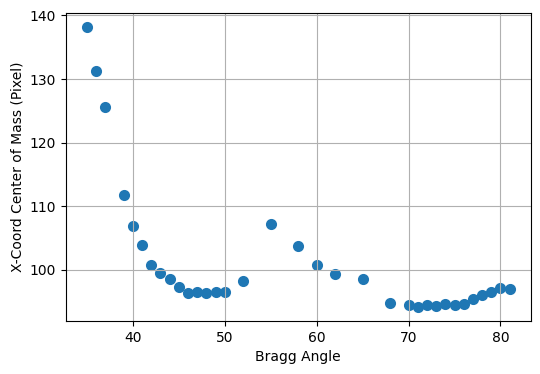

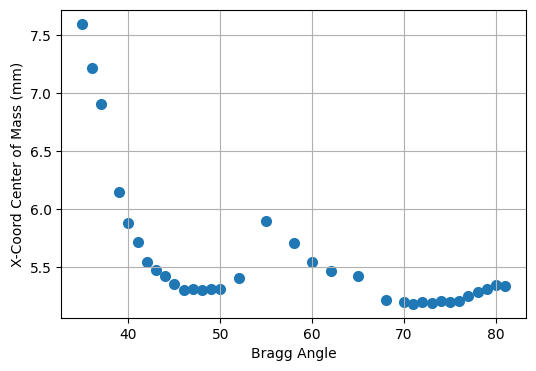

In [42]:
fig, ax = plt.subplots(figsize = (6,4))
ax.scatter(ang, com, linewidth=2.0)
ax.set_xlabel('Bragg Angle')
ax.set_ylabel('X-Coord Center of Mass (Pixel)')
ax.grid(True)

fig2, ax2 = plt.subplots(figsize = (6,4))
ax2.scatter(ang, com_mm, linewidth=2.0)
ax2.set_xlabel('Bragg Angle')
ax2.set_ylabel('X-Coord Center of Mass (mm)')
ax2.grid(True)

#camera is about 14mm x 14mm

['35_deg.txt', '36_deg.txt', '37_deg.txt', '38_deg.txt', '39_deg.txt', '40_deg.txt', '41_deg.txt', '42_deg.txt', '43_deg.txt', '44_deg.txt', '45_deg.txt', '46_deg.txt', '47_deg.txt', '48_deg.txt', '49_deg.txt', '50_deg.txt', '52_deg.txt', '55_deg.txt', '58_deg.txt', '60_deg.txt', '62_deg.txt', '65_deg.txt', '68_deg.txt', '70_deg.txt', '71_deg.txt', '72_deg.txt', '73_deg.txt', '74_deg.txt', '75_deg.txt', '76_deg.txt', '77_deg.txt', '78_deg.txt', '79_deg.txt', '80_deg.txt', '81_deg.txt', '82_deg.txt', '83_deg.txt']


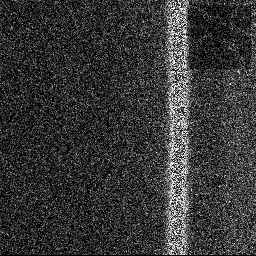

In [43]:
print(list(file_list(d, typ)))

pic = txt_to_list('/Users/anthonygironda/Desktop/Rowland_Tracking/55_deg.txt')
p1 = xcam_image(55, pic)
p1.set_norm(10)
# p1.set_norm_to_max()
p1.set_rot(90)
p1.show_pic()


# pic2 = txt_to_list('/Users/anthonygironda/Desktop/Rowland_Tracking/70_deg.txt')
# p2 = xcam_image(70, pic2)
# p2.set_norm_to_max()
# p2.set_rot(270)
# p2.show_pic()

# pic3 = txt_to_list('/Users/anthonygironda/Desktop/Rowland_Tracking/80_deg.txt')
# p3 = xcam_image(80, pic3)
# p3.set_norm_to_max()
# p3.set_rot(270)
# p3.show_pic()

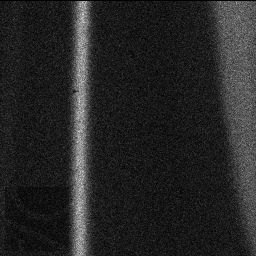

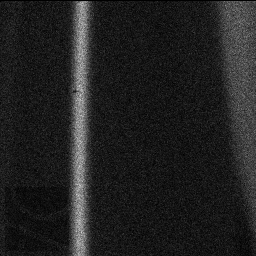

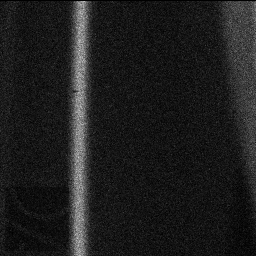

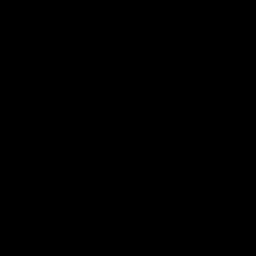

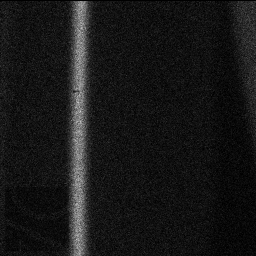

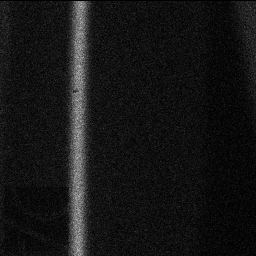

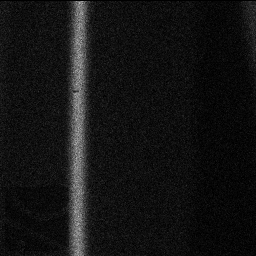

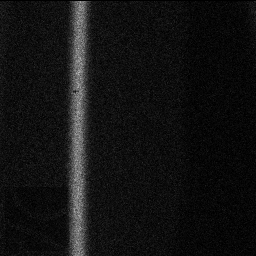

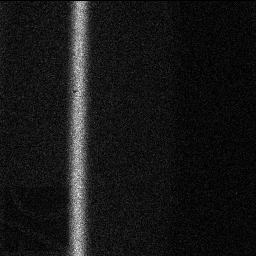

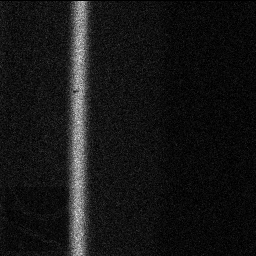

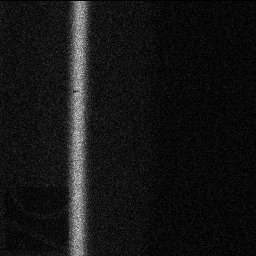

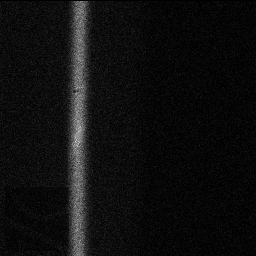

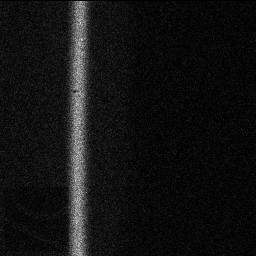

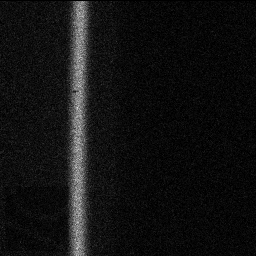

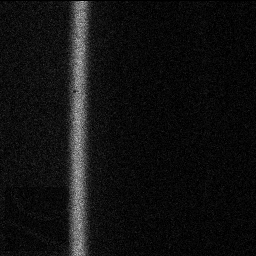

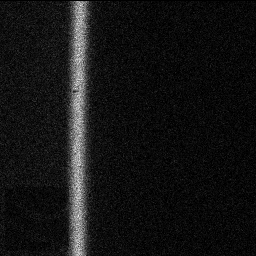

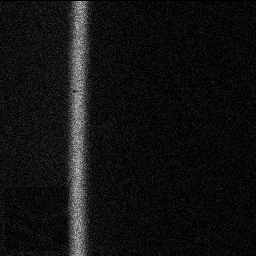

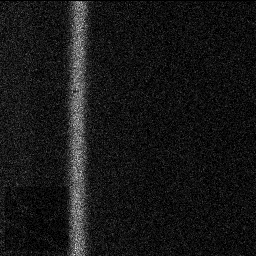

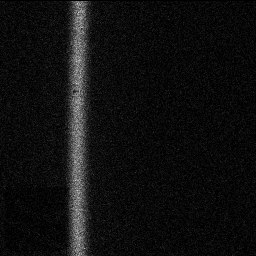

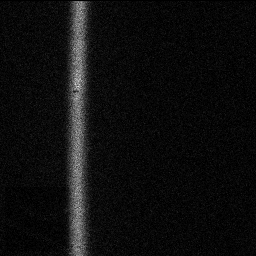

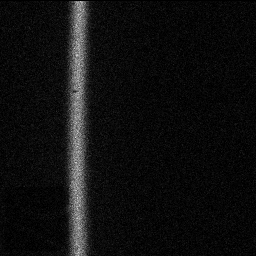

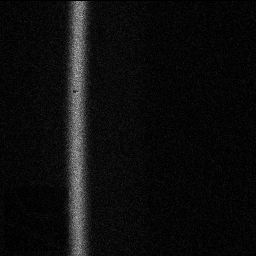

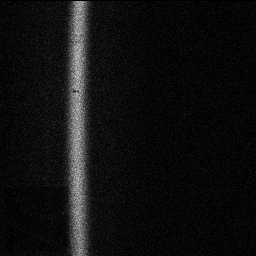

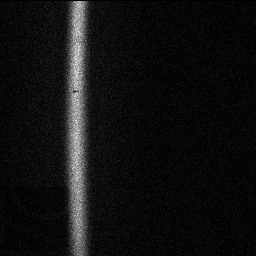

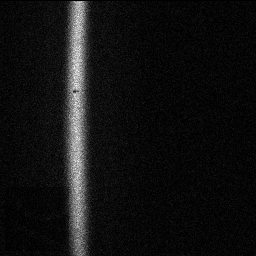

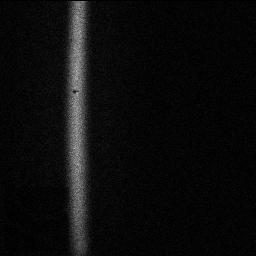

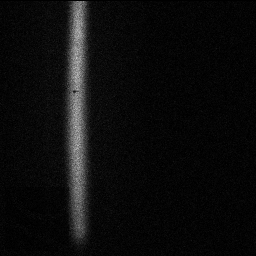

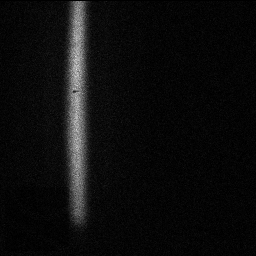

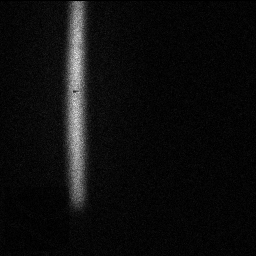

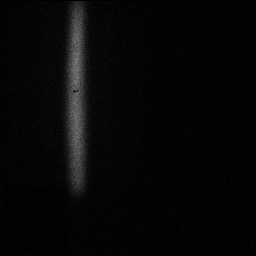

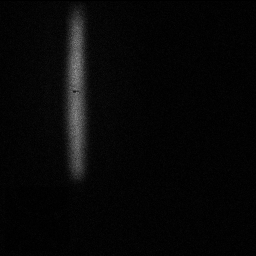

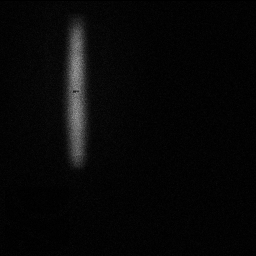

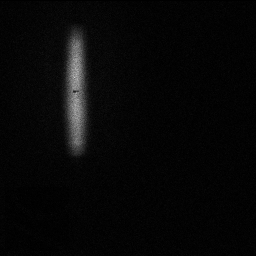

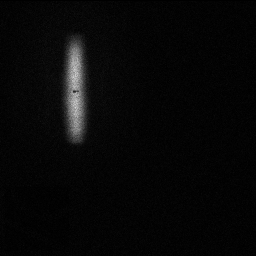

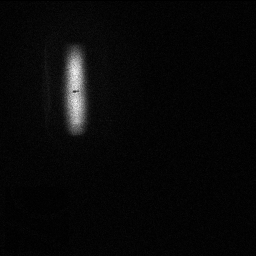

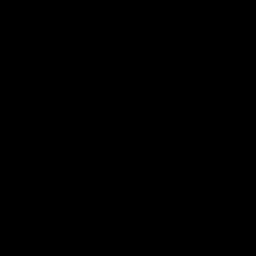

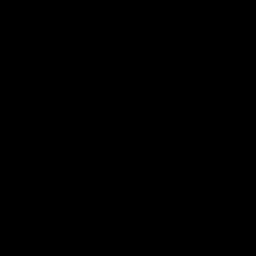

In [44]:
for k in range(len(cam_list)):
    cam_list[k].show_pic()

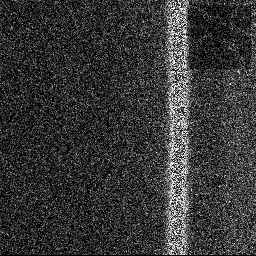

In [45]:
p1.show_pic()

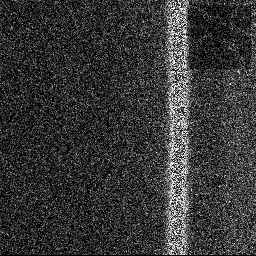

In [46]:
p1.show_pic()

In [47]:
a= p1.get_nparray()
ndi.center_of_mass(a)


(129.80134785600723, 143.4281274209691)

In [48]:
y = [[1,2,3],[4,5,6],[7,8,9]]
testy = camimage(50, y)
testy.gen_pic()

NameError: name 'camimage' is not defined

In [49]:
print(testy.get_name())
print(testy.get_xpixct())
print(testy.get_ypixct())
print(testy.get_pixct())
print(testy.get_dim())
print(testy.get_res())
print(testy.get_rot())
print(testy.get_norm())
print(testy.get_pixsize())
print(testy.get_maxcounts())


NameError: name 'testy' is not defined

In [50]:
testy.set_norm(10)
testy.set_rot(90)
testy.set_pixsize(55)
testy.set_norm_to_max()

NameError: name 'testy' is not defined

In [51]:
deg40 = txt_to_list('/Users/anthonygironda/Desktop/Rowland_Tracking/40_deg.txt')
p1 = camimage(40, deg40)
deg80 = txt_to_list('/Users/anthonygironda/Desktop/Rowland_Tracking/80_deg.txt')
p2 = camimage(80, deg80)

p1.pic()

NameError: name 'camimage' is not defined

In [47]:
deg40 = txt_to_list('/Users/anthonygironda/Desktop/Rowland_Tracking/83_deg.txt')
p1 = camimage(80, deg40)
p1.pic()
p1.set_rot(90)
p1.pic()
# im.fromarray(p1.p1.rotate(90)imagearray)
img = p1.pic()
img.resize(size=(400, 400))


NameError: name 'camimage' is not defined